In [1]:
//%jsroot on
TFile *ipf = new TFile("../SeperateData/decay47_128.root");
TTree *tree = (TTree*)ipf->Get("tree");
TCanvas *c1 = new TCanvas;

## 提取时间零点

In [2]:
TH1D *ht;
double offset = 0;

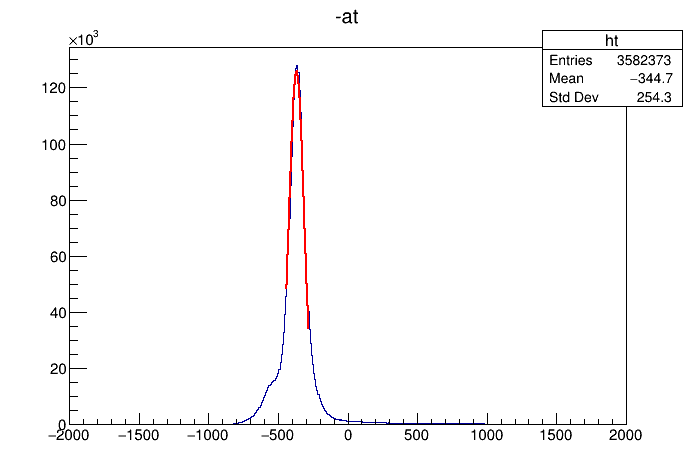

 FCN=631.476 FROM MIGRAD    STATUS=CONVERGED      73 CALLS          74 TOTAL
                     EDM=3.13933e-09    STRATEGY= 1  ERROR MATRIX UNCERTAINTY   1.9 per cent
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     1.25674e+05   1.29184e+02   3.64030e-01  -4.30328e-07
   2  Mean        -3.66143e+02   5.38525e-02   4.05129e-05  -3.11082e-04
   3  Sigma        5.29503e+01   6.81357e-02  -1.38336e-06   1.14176e-01

Offset = 366.143


In [3]:
tree->Draw("-at>>ht(500,-2000,2000)");
ht = (TH1D*)gROOT->FindObject("ht");
ht->Fit("gaus","","",-440,-280);
offset = -ht->GetFunction("gaus")->GetParameter(1);
cout<<'\n'<<"Offset = "<<offset<<'\n';
c1->Draw();

## 投影谱

扣长寿命本底

In [4]:
%jsroot on
tree->Draw("ae>>h1(1500,0,1500)","decaytime>10 && decaytime<180");
tree->Draw("ae>>h2(1500,0,1500)","decaytime>4010 && decaytime<4180");
TH1D *h1 = (TH1D*)gROOT->FindObject("h1");
TH1D *h2 = (TH1D*)gROOT->FindObject("h2");
//h1->Add(h2,-1);
h1->Draw();
c1->Draw();

## 二维谱

扣长寿命本底

In [5]:
int nbins = 440;

In [6]:
%jsroot on
tree->Draw(Form("ae:%.3f-at>>hh1(%d,-2000,20000,1500,0,1500)",offset,nbins),"decaytime>10 && decaytime<180","colz");
tree->Draw(Form("ae:%.3f-at>>hh2(%d,-2000,20000,1500,0,1500)",offset,nbins),"decaytime>4010 && decaytime<4180","colz");
TH2D *hh1 = (TH2D*)gROOT->FindObject("hh1");
TH2D *hh2 = (TH2D*)gROOT->FindObject("hh2");
//hh1->Add(hh2,-1);
hh1->Draw("colz");
c1->SetLogz();
c1->Draw();

## 卷积拟合函数

设探测器冲激响应为高斯函数，时间分辨为$\sigma$
$$
g(x)=e^{-\frac{x^2}{2\sigma^2}}
$$
激发态衰变时间为指数分布，寿命为$\tau$
$$
f(x)=Ae^{-\frac{x}{\tau}}\ \ (x>0)
$$
则总的时间分布为$f(x)$与$g(x)$的卷积
$$
F(x)=\int_0^{+\infty}f(x')\ g(x-x')\ dx'
$$
代入$f(x)$与$g(x)$表达式，整理得
$$
F(x)=A\int_0^{+\infty}e^{-\frac12[\frac{x'}{\sigma}+(\frac{\sigma}{\tau}-\frac{x}{\sigma})]^2-(\frac{x}{\tau}-\frac{\sigma^2}{2\tau^2})}\ dx'
$$
换元$u=\frac{x'}{\sigma}+(\frac{\sigma}{\tau}-\frac{x}{\sigma})$，得
$$
F(x)=\sigma{A}\ e^{-(\frac{x}{\tau}-\frac{\sigma^2}{2\tau^2})}\int_{\frac{\sigma}{\tau}-\frac{x}{\sigma}}^{+\infty}e^{-\frac{u^2}{2}}\ du
$$
最后得
$$
F(x)\propto{e}^{-\frac{x}{\tau}}(\sqrt{\frac{\pi}{2}}-\int^{\frac{\sigma}{\tau}-\frac{x}{\sigma}}_0e^{-\frac{u^2}{2}}\ du)
$$
用$F(x)$对时间分布进行拟合，就可以得到探测器时间分辨$\sigma$和激发态寿命$\tau$。

In [7]:
double conv(double x, double tau, double sigma)
{
    TF1 *ftemp = new TF1("ftemp", "TMath::Exp(-x**2/2)", -1e4, 1e4);
    
    double result = TMath::Exp(-x/tau) * ( sqrt(TMath::Pi()/2) - ftemp->Integral(0, sigma/tau - x/sigma) );
    
    delete ftemp;
    
    return result;
}

## 单指数成分（卷积） + 高斯

适用于270ns isomer与3us isomer之间的跃迁

路径1：直接布居，呈现prompt特征，对应高斯成分（高斯的sigma与探测器冲激响应相同）

路径2：从3us isomer退激，对应指数成分（卷积）

In [8]:
double ff1(double *val, double *par)
{
    double x = val[0];
    
    double constant = par[0];
    double Aprompt = par[1];
    double sigma = par[2];
    double Adelay1 = par[3];
    double tau1 = par[4]/TMath::Log(2);
    
    double result = constant + Aprompt * TMath::Exp(-x*x/2/sigma/sigma) + Adelay1 * conv(x, tau1, sigma);
    
    return result;
}

## 双指数成分（卷积） + 高斯

适用于270ns isomer以下的跃迁

路径1：直接布居，呈现prompt特征，对应高斯成分（高斯的sigma与探测器冲激响应相同）

路径2：经过了270ns isomer退激，对应指数成分1（卷积）

路径3：从3us isomer经过270ns isomer退激，对应指数成分2（级联衰变规律，卷积）

In [9]:
double ff2(double *val, double *par)
{
    double x = val[0];
    
    double constant = par[0];
    double Aprompt = par[1];
    double sigma = par[2];
    double Adelay1 = par[3];
    double tau1 = par[4]/TMath::Log(2);
    double Adelay2 = par[5];
    double tau2 = par[6]/TMath::Log(2);
    
    double result = constant + Aprompt * TMath::Exp(-x*x/2/sigma/sigma) + Adelay1 * conv(x, tau1, sigma) + Adelay2 * ( conv(x, tau2, sigma) - conv(x, tau1, sigma) );
    
    return result;
}

#### 用于提取指数成分的全空间积分

In [10]:
double fconv(double *val, double *par)
{
    double x = val[0];
    
    double A = par[0];
    double tau = par[1]/TMath::Log(2);
    double sigma = par[2];
    
    double result = A * conv(x, tau, sigma);
    
    return result;
}

## 左右开窗

In [11]:
Int_t e,e1,e2;  // gate range: (e1,e2)
vector<int> b;  // bg range:   (b[i],b[i]+1)
int xmin, xmax;
TRandom3 *gr = new TRandom3(0);
double p0[7];

In [12]:
double norm1 = TMath::Exp(-TMath::Log(2)/60.*10.) - TMath::Exp(-TMath::Log(2)/60.*180.);

In [13]:
void gate(int type, double eff)
{
    hh1->ProjectionX(Form("h%d",e),e1,e2);
    TH1D *hdt = (TH1D*)gROOT->FindObject(Form("h%d",e));
    TH1D *hbg = new TH1D("hbg","hbg",nbins,-2000,20000);
    for (unsigned int i=0;i<b.size();i++){
        hh1->ProjectionX(Form("b%d",b[i]),b[i],b[i]);
        TH1D *hbtemp = (TH1D*)gROOT->FindObject(Form("b%d",b[i]));
        hbg->Add(hbg,hbtemp,1,1);
    }
    double weight = (double)(e2-e1+1)/b.size();
    hdt->Add(hdt,hbg,1,-weight);
    
    TF1 *f1;
    if (type==3){  // two components + prompt
        f1 = new TF1("ff2",ff2,xmin,xmax,7);
        f1->SetParameter(3,100);
        f1->SetParLimits(3,0,1e8);
        f1->SetParameter(4,270);
        f1->SetParLimits(4,0,1e8);
        f1->SetParameter(5,10);
        f1->SetParLimits(5,0,1e8);
        f1->SetParameter(6,3000);
        f1->SetParLimits(6,2000,4000);
    }
    if (type==4){  // one component + prompt
        f1 = new TF1("ff1",ff1,xmin,xmax,5);
        f1->SetParameter(3,10);
        f1->SetParLimits(3,0,1e8);
        f1->SetParameter(4,3000);
        f1->SetParLimits(4,2000,4000);
    }
    f1->SetNpx(xmax-xmin);
    f1->FixParameter(0,0);
    f1->SetParameter(1,1000);
    f1->SetParLimits(1,0,1e8);
    f1->SetParameter(2,50);
    f1->SetParLimits(2,30,100);
    
    hdt->Fit(f1,"RL");
    hdt->Draw();
    c1->Draw();
    
    if (type==3){
        cout<<'\n'<<"T1/2 = prompt and "<<f1->GetParameter(4)<<" and "<<f1->GetParameter(6)<<" ns"<<endl;
        
        TF1 *fgaus = new TF1(Form("fgaus_%d",e),"gaus",-2000,20000);
        fgaus->SetParameter(0, f1->GetParameter(1));
        fgaus->SetParameter(1, 0);
        fgaus->SetParameter(2, f1->GetParameter(2));
        
        TF1 *fconv1 = new TF1(Form("fconv1_%d",e),fconv,-2000,20000,3);
        fconv1->SetParameter(0, f1->GetParameter(3));
        fconv1->SetParameter(1, f1->GetParameter(4));
        fconv1->SetParameter(2, f1->GetParameter(2));
        
        TF1 *fconv2 = new TF1(Form("fconv2_%d",e),fconv,-2000,20000,3);
        fconv2->SetParameter(0, f1->GetParameter(5));
        fconv2->SetParameter(1, f1->GetParameter(6));
        fconv2->SetParameter(2, f1->GetParameter(2));
        
        TF1 *fconv22 = new TF1(Form("fconv22_%d",e),fconv,-2000,20000,3);
        fconv22->SetParameter(0, f1->GetParameter(5));
        fconv22->SetParameter(1, f1->GetParameter(4));
        fconv22->SetParameter(2, f1->GetParameter(2));
        
        ofstream ifs(Form("spectra/Delay_Fit_hist_%d",e));
        for (int i=1; i<=440; i++)
            ifs<<hdt->GetBinLowEdge(i)+hdt->GetBinWidth(i)/2.<<'\n';
        ifs<<'\n';
        for (int i=1; i<=440; i++)
            ifs<<hdt->GetBinContent(i)<<'\n';
        ifs.close();
        
        ofstream ifs0(Form("spectra/Delay_Fit_gaus_%d",e));
        for (int i=-2000; i<=20000; i+=10)
            ifs0<<i<<'\n';
        ifs0<<'\n';
        for (int i=-2000; i<=20000; i+=10)
            ifs0<<fgaus->Eval(i)<<'\n';
        ifs0.close();
        
        ofstream ifs1(Form("spectra/Delay_Fit_conv1_%d",e));
        for (int i=-2000; i<=20000; i+=10)
            ifs1<<i<<'\n';
        ifs1<<'\n';
        for (int i=-2000; i<=20000; i+=10)
            ifs1<<fconv1->Eval(i)<<'\n';
        ifs1.close();
        
        ofstream ifs2(Form("spectra/Delay_Fit_conv2_%d",e));
        for (int i=-2000; i<=20000; i+=10)
            ifs2<<i<<'\n';
        ifs2<<'\n';
        for (int i=-2000; i<=20000; i+=10)
            ifs2<<fconv2->Eval(i)-fconv22->Eval(i)<<'\n';
        ifs2.close();

        // /eff/50/norm1
        cout<<'\n'<<"integral = "<<fgaus->Integral(-1000,10000)<<" and "<<fconv1->Integral(-1000,10000)<<" and "<<(fconv2->Integral(-1000,10000) - fconv22->Integral(-1000,10000))<<endl;
        
        TH1D *hgaus = new TH1D("hgaus","hgaus",10000,0,1000000);
        TH1D *hconv1 = new TH1D("hconv1","hconv1",10000,0,1000000);
        TH1D *hconv2 = new TH1D("hconv2","hconv2",10000,0,1000000);
        
        double p[7];
        for (int i=0; i<1000; i++){
            for (int ipar=0; ipar<7; ipar++)
                p[ipar] = gr->Gaus(f1->GetParameter(ipar), f1->GetParError(ipar));
            
            fgaus->SetParameter(0, p[1]);
            fgaus->SetParameter(1, 0);
            fgaus->SetParameter(2, p[2]);

            fconv1->SetParameter(0, p[3]);
            fconv1->SetParameter(1, p[4]);
            fconv1->SetParameter(2, p[2]);

            fconv2->SetParameter(0, p[5]);
            fconv2->SetParameter(1, p[6]);
            fconv2->SetParameter(2, p[2]);

            fconv22->SetParameter(0, p[5]);
            fconv22->SetParameter(1, p[4]);
            fconv22->SetParameter(2, p[2]);
            
            hgaus->Fill(fgaus->Integral(-2000,20000));
            hconv1->Fill(fconv1->Integral(-2000,20000));
            hconv2->Fill((fconv2->Integral(-2000,20000) - fconv22->Integral(-2000,20000)));
        }
        
        cout<<"integral error = "<<hgaus->GetStdDev()<<" and "<<hconv1->GetStdDev()<<" and "<<hconv2->GetStdDev()<<endl;
        
        delete hgaus;
        delete hconv1;
        delete hconv2;
    }
    if (type==4){
        cout<<'\n'<<"T1/2 = prompt and "<<f1->GetParameter(4)<<" ns"<<endl;
        
        TF1 *fgaus = new TF1(Form("fgaus_%d",e),"gaus",-2000,20000);
        fgaus->SetParameter(0, f1->GetParameter(1));
        fgaus->SetParameter(1, 0);
        fgaus->SetParameter(2, f1->GetParameter(2));
        
        TF1 *fconv1 = new TF1(Form("fconv1_%d",e),fconv,-2000,20000,3);
        fconv1->SetParameter(0, f1->GetParameter(3));
        fconv1->SetParameter(1, f1->GetParameter(4));
        fconv1->SetParameter(2, f1->GetParameter(2));
        
        ofstream ifs(Form("spectra/Delay_Fit_hist_%d",e));
        for (int i=1; i<=440; i++)
            ifs<<hdt->GetBinLowEdge(i)+hdt->GetBinWidth(i)/2.<<'\n';
        ifs<<'\n';
        for (int i=1; i<=440; i++)
            ifs<<hdt->GetBinContent(i)<<'\n';
        ifs.close();
        
        ofstream ifs0(Form("spectra/Delay_Fit_gaus_%d",e));
        for (int i=-2000; i<=20000; i+=10)
            ifs0<<i<<'\n';
        ifs0<<'\n';
        for (int i=-2000; i<=20000; i+=10)
            ifs0<<fgaus->Eval(i)<<'\n';
        ifs0.close();
        
        ofstream ifs1(Form("spectra/Delay_Fit_conv1_%d",e));
        for (int i=-2000; i<=20000; i+=10)
            ifs1<<i<<'\n';
        ifs1<<'\n';
        for (int i=-2000; i<=20000; i+=10)
            ifs1<<fconv1->Eval(i)<<'\n';
        ifs1.close();
        
        cout<<'\n'<<"integral = "<<fgaus->Integral(-2000,20000)<<" and "<<fconv1->Integral(-2000,20000)<<endl;
        
        TH1D *hgaus = new TH1D("hgaus","hgaus",10000,0,1000000);
        TH1D *hconv1 = new TH1D("hconv1","hconv1",10000,0,1000000);
        
        double p[5];
        for (int i=0; i<1000; i++){
            for (int ipar=0; ipar<5; ipar++)
                p[ipar] = gr->Gaus(f1->GetParameter(ipar), f1->GetParError(ipar));
            
            fgaus->SetParameter(0, p[1]);
            fgaus->SetParameter(1, 0);
            fgaus->SetParameter(2, p[2]);

            fconv1->SetParameter(0, p[3]);
            fconv1->SetParameter(1, p[4]);
            fconv1->SetParameter(2, p[2]);
            
            hgaus->Fill(fgaus->Integral(-2000,20000));
            hconv1->Fill(fconv1->Integral(-2000,20000));
        }
        
        cout<<"integral error = "<<hgaus->GetStdDev()<<" and "<<hconv1->GetStdDev()<<endl;
        
        delete hgaus;
        delete hconv1;
    }
    delete hbg;
}

In [14]:
c1->SetLogy();
xmin = -120;
xmax = 20000;

In [15]:
%jsroot off

 FCN=224.178 FROM MIGRAD    STATUS=CONVERGED     213 CALLS         214 TOTAL
                     EDM=5.65524e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           0.00000e+00     fixed    
   2  p1           1.92705e+03   4.08384e+01   7.44828e-07   1.69774e-01
   3  p2           5.00684e+01   8.81099e-01   2.19129e-04  -4.35706e-03
   4  p3           2.88855e+02   8.08174e+00   7.47393e-07  -2.29725e+00
   5  p4           2.69216e+02   6.21602e+00   7.47449e-07   1.87725e+01
   6  p5           9.47582e+00   4.54989e-01   7.48720e-07** at limit **
   7  p6           3.62558e+03   1.16157e+02   8.00227e-04  -1.63945e-03
                               ERR DEF= 0.5

T1/2 = prompt and 269.216 and 3625.58 ns

integral = 241850 and 278893 and 96720.6


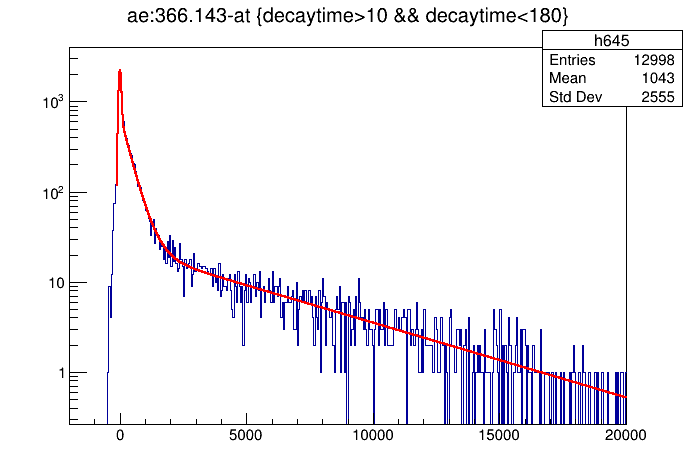

integral error = 6465.96 and 10117 and 6312.31


In [16]:
e=645;
e1=643;
e2=648;
b={640,641,642,649,650,651};
gate(3, 0.096);

 FCN=231.641 FROM MIGRAD    STATUS=CONVERGED     243 CALLS         244 TOTAL
                     EDM=1.97157e-09    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           0.00000e+00     fixed    
   2  p1           5.99154e+02   2.64395e+01   8.55478e-07   8.14029e-02
   3  p2           4.79598e+01   1.48276e+00   4.05384e-04   2.49625e-04
   4  p3           2.41670e+02   6.78550e+00   7.47531e-07   1.98658e-01
   5  p4           2.74724e+02   6.52493e+00   7.47433e-07   7.49790e-01
   6  p5           7.87491e+00   4.12513e-01   7.48746e-07** at limit **
   7  p6           3.66685e+03   1.28727e+02   9.41520e-04  -3.18524e-04
                               ERR DEF= 0.5

T1/2 = prompt and 274.724 and 3666.85 ns

integral = 72028.8 and 238344 and 80883.2


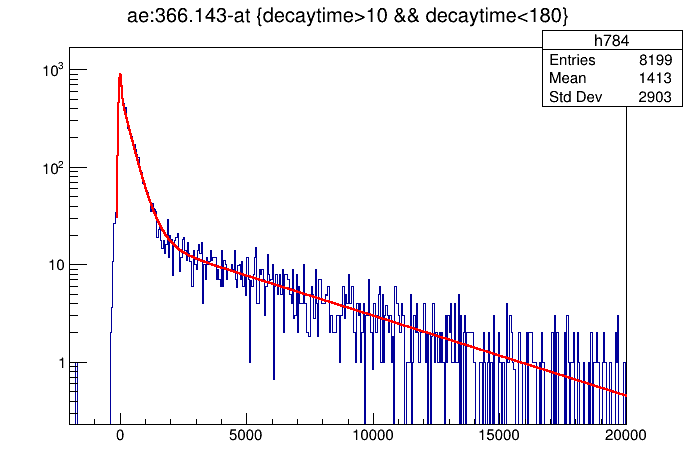

integral error = 3710.31 and 8812.44 and 5960.39


In [17]:
e=784;
e1=781;
e2=787;
b={778,779,780,788,789,790};
gate(3, 0.0885);

 FCN=254.675 FROM MIGRAD    STATUS=CONVERGED     312 CALLS         313 TOTAL
                     EDM=7.83165e-08    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           0.00000e+00     fixed    
   2  p1           0.00000e+00   1.73201e+00   2.90341e-06** at limit **
   3  p2           5.36151e+01   2.46603e+00   8.17273e-04   1.02858e-03
   4  p3           2.98042e+02   6.18081e+00   7.47368e-07  -7.23271e+00
   5  p4           2.79996e+02   5.52029e+00   7.47418e-07  -6.20802e-01
   6  p5           9.76780e+00   4.79420e-01   7.48716e-07** at limit **
   7  p6           3.51151e+03   1.12337e+02   7.39695e-04   9.24021e-04
                               ERR DEF= 0.5

T1/2 = prompt and 279.996 and 3511.51 ns

integral = 0 and 299136 and 96997.3


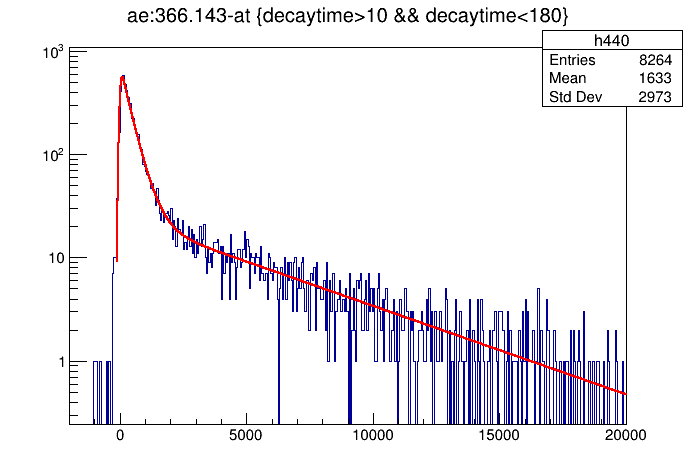

integral error = 140.114 and 8610.95 and 6477.19


In [18]:
e=440;
e1=437;
e2=442;
b={434,435,436,443,444,445};
gate(3, 0.1126);

 FCN=188.1 FROM MIGRAD    STATUS=CONVERGED     826 CALLS         827 TOTAL
                     EDM=1.77073e-08    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           0.00000e+00     fixed    
   2  p1           2.06158e+00   4.93339e+00   2.40937e-06** at limit **
   3  p2           3.55924e+01   6.58877e+00   2.75426e-03  -2.23821e-05
   4  p3           2.02595e+01   1.78818e+00   7.48585e-07** at limit **
   5  p4           2.89442e+02   2.13378e+01   7.47392e-07   8.06430e-01
   6  p5           6.04957e-01   5.76413e-02   7.48940e-07** at limit **
   7  p6           4.00000e+03   1.99269e+03   2.77465e-02** at limit **
                               ERR DEF= 0.5

T1/2 = prompt and 289.442 and 4000 ns

integral = 183.927 and 21128.9 and 6572.8


Error in <GSLError>: Error 11 in qags.c at 543 : number of iterations was insufficient
Warning in <TF1::IntegralOneDim>: Error found in integrating function fconv2_1224 in [-2000.000000,20000.000000] using AdaptiveSingular. Result = 128.147089 +/- 0.000003  - status = 11
Info in <TF1::IntegralOneDim>: 		Function Parameters = { p0 =  0.638272 , p1 =  59.791356 , p2 =  33.217065 }
Error in <GSLError>: Error 11 in qags.c at 543 : number of iterations was insufficient
Warning in <TF1::IntegralOneDim>: Error found in integrating function fconv2_1224 in [-2000.000000,20000.000000] using AdaptiveSingular. Result = 137.371060 +/- 0.000000  - status = 11
Info in <TF1::IntegralOneDim>: 		Function Parameters = { p0 =  0.598182 , p1 =  71.403306 , p2 =  49.884291 }
Error in <GSLError>: Error 11 in qags.c at 543 : number of iterations was insufficient
Warning in <TF1::IntegralOneDim>: Error found in integrating function fconv2_1224 in [-2000.000000,20000.000000] using AdaptiveSingular. Result = 144

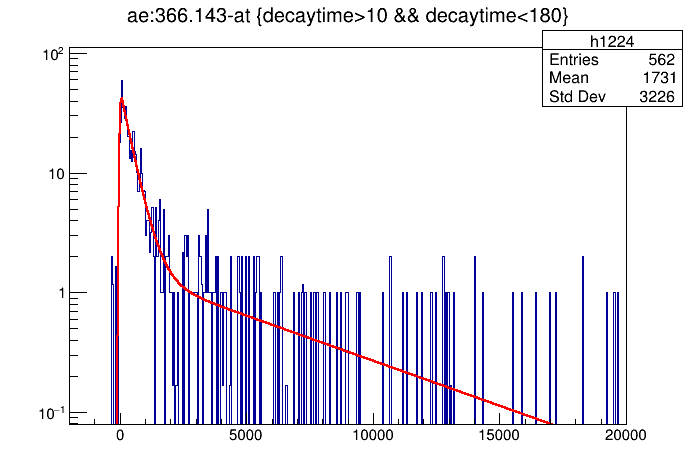

integral error = 315.958 and 2416.22 and 3501.8


In [19]:
e=1224;
e1=1222;
e2=1226;
b={1219,1220,1221,1227,1228,1229};
gate(3, 0.0737);

 FCN=369.393 FROM MIGRAD    STATUS=CONVERGED     116 CALLS         117 TOTAL
                     EDM=6.82802e-09    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           0.00000e+00     fixed    
   2  p1           1.80954e+03   3.03143e+01   7.47003e-07  -7.44087e-01
   3  p2           6.93545e+01   1.00526e+00   3.00688e-04  -3.22074e-03
   4  p3           1.21610e+01   3.51524e-01   7.48681e-07** at limit **
   5  p4           3.51362e+03   7.95931e+01   7.96950e-04   3.55630e-04
                               ERR DEF= 0.5

T1/2 = prompt and 3513.62 ns

integral = 314581 and 151518


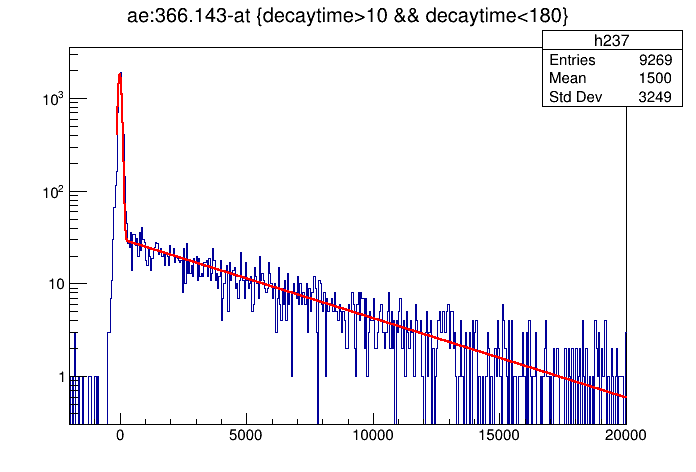

integral error = 7079.48 and 5469.38


In [20]:
e=237;
e1=235;
e2=240;
b={232,233,234,240,241,242};
gate(4, 0.1404);

 FCN=262.649 FROM MIGRAD    STATUS=CONVERGED     123 CALLS         124 TOTAL
                     EDM=1.89079e-08    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           0.00000e+00     fixed    
   2  p1           6.36484e+02   2.11890e+01   7.46608e-07  -7.06394e-01
   3  p2           4.96195e+01   1.24367e+00   3.42292e-04  -3.46664e-03
   4  p3           8.78526e+00   2.87130e-01   7.48731e-07** at limit **
   5  p4           3.58785e+03   9.38731e+01   8.54525e-04  -7.94592e-04
                               ERR DEF= 0.5

T1/2 = prompt and 3587.85 ns

integral = 79164.4 and 111589


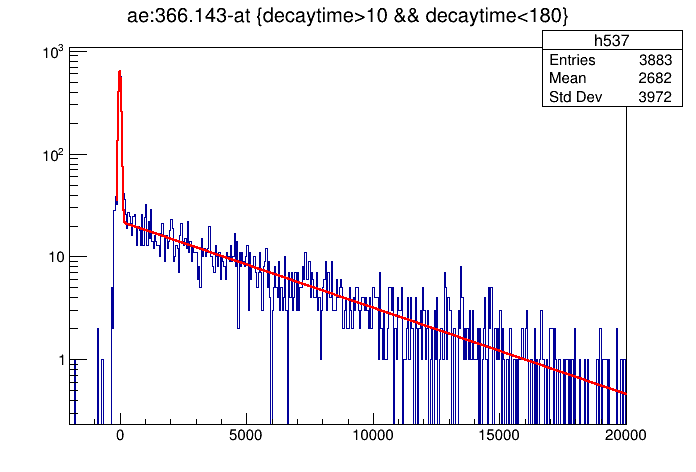

integral error = 3361.27 and 4656.82


In [21]:
e=537;
e1=535;
e2=540;
b={532,533,534,541,542,543};
gate(4, 0.1037);

In [22]:
xmin = 500;

 FCN=484.576 FROM MIGRAD    STATUS=CONVERGED      88 CALLS          89 TOTAL
                     EDM=1.10575e-09    STRATEGY= 1  ERROR MATRIX UNCERTAINTY   0.8 per cent
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           0.00000e+00     fixed    
   2  p1           1.00000e+03   7.07685e+07  -0.00000e+00   0.00000e+00
   3  p2           5.00004e+01   5.94304e+01   1.40382e-06  -3.75167e-11
   4  p3           2.16975e+00   9.20178e-02   1.50675e-08** at limit **
   5  p4           4.00000e+03   1.76827e+01  -4.80072e-05** at limit **
                               ERR DEF= 0.5

T1/2 = prompt and 4000 ns

integral = 125332 and 30403.8


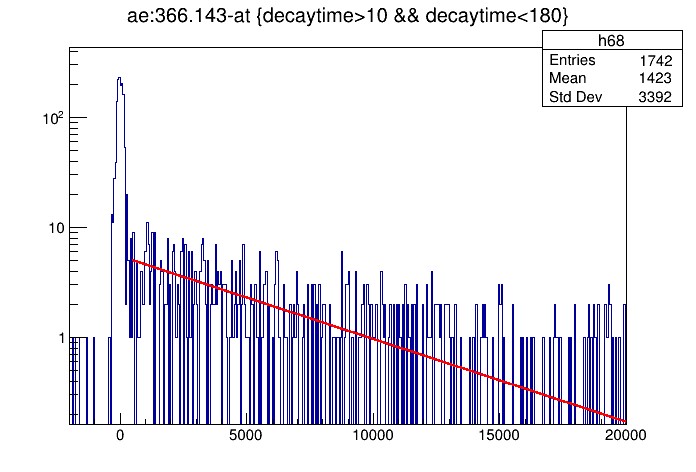

integral error = 0 and 6839.51


In [23]:
e=68;
e1=67;
e2=70;
b={66,71};
gate(4, 0.1185);